# Bankruptcy Prediction Taiwan
###### Final Project Report by Tobias Unterhauser

#### Rational including the open issues and research questions
The goal of this study was to identify the most effective classification model for predicting bankruptcy using data from the Taiwan Economic Journal. Bankruptcy prediction is an important field in finance. This prediction can help stakeholders like employees, shareholders and customers make decisions to avoid potential losses when there is a high risk of financial distress. This can be very helpful as for the single stakeholder it might be too difficult to analyze all the data at hand and interpret it by himself. 

To reach this goal, a dataset from the Taiwan Economic Journal containing financial data for a large number of publicly traded companies was analyzed. I selected a range of financial indicators that have been shown to be predictive of bankruptcy and have the highest correlation with the target class, including profitability, liquidity, leverage, and solvency ratios. In the next step different machine learning algorithms were trained on to the data and their predictions were compared by using different performance metrics. The best-performing models were further tuned in order to obtain a model with the most accurate prediction for our use case.

#### Description of the data-set
The dataset was taken from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction). The data  was collected from the Taiwan Economic Journal and covers the time period from 1999 - 2009. Whether a company was bankrupt or not was defined based on the business regulations of the Taiwan Stock Exchange. It contains 95 Financial metrics and the target class which states whether a company is bankrupt or not. Having some domain knowledge I know that some of the metrics are going to be redundant as some are calculated similarly and therefore will have a high correlation to each other. In addition not in every case of bankruptcy there is a direct link to the financial metrics as there may be also other external influences impacting the company. Nonetheless based on financial metrics the health of a company can be determined and classified in order to make a good enough prediction. A challange is going to be the high class imbalance in the target class as we will see during the data exploration.

###### Library Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve,plot_roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
data = pd.read_csv('data.csv')

## Data Exploration and Preprocessing



As we see we have 96 columns and 6819 rows in our data frame. With 93 financial metrics with float values, 2 flag values and the target class using integer data types.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

#### Check for null values and duplicates
We can already observe from the previous visualization that there are no null values in the dataset. Here we make a second check for that. In addition we also check for duplicates, which also are none in the dataset.

In [4]:
print("Number of null values: {}".format(data.isnull().sum().sum()))
print("Number of duplicated values: {}".format(data.duplicated().sum()))

Number of null values: 0
Number of duplicated values: 0


#### Taking a look at the two *Flag* features
The *Liability-Assets Flag* is 1 if Total Liabilities exceed total assets and 0 otherwise. We know that the debt ratio attribute present in the dataset expresses the same information in a more precise way. Therefore we can drop the Liability-Assets Flag as it is redundant.

The *Net Income Flag* is 1 if Net Income is Negative for the last two years and 0 otherwise. But we can observe that in the data-set at hand the net income flag is 1 for every entry. Such features has no use for our prediction model and we can drop this flag too.

In [5]:
nif = len(data[data[' Net Income Flag'] != 1])

print("Number of rows where Net Incom Flag is not 1: {}".format(nif))

Number of rows where Net Incom Flag is not 1: 0


In [6]:
data = data.drop([' Net Income Flag', ' Liability-Assets Flag'], axis=1)

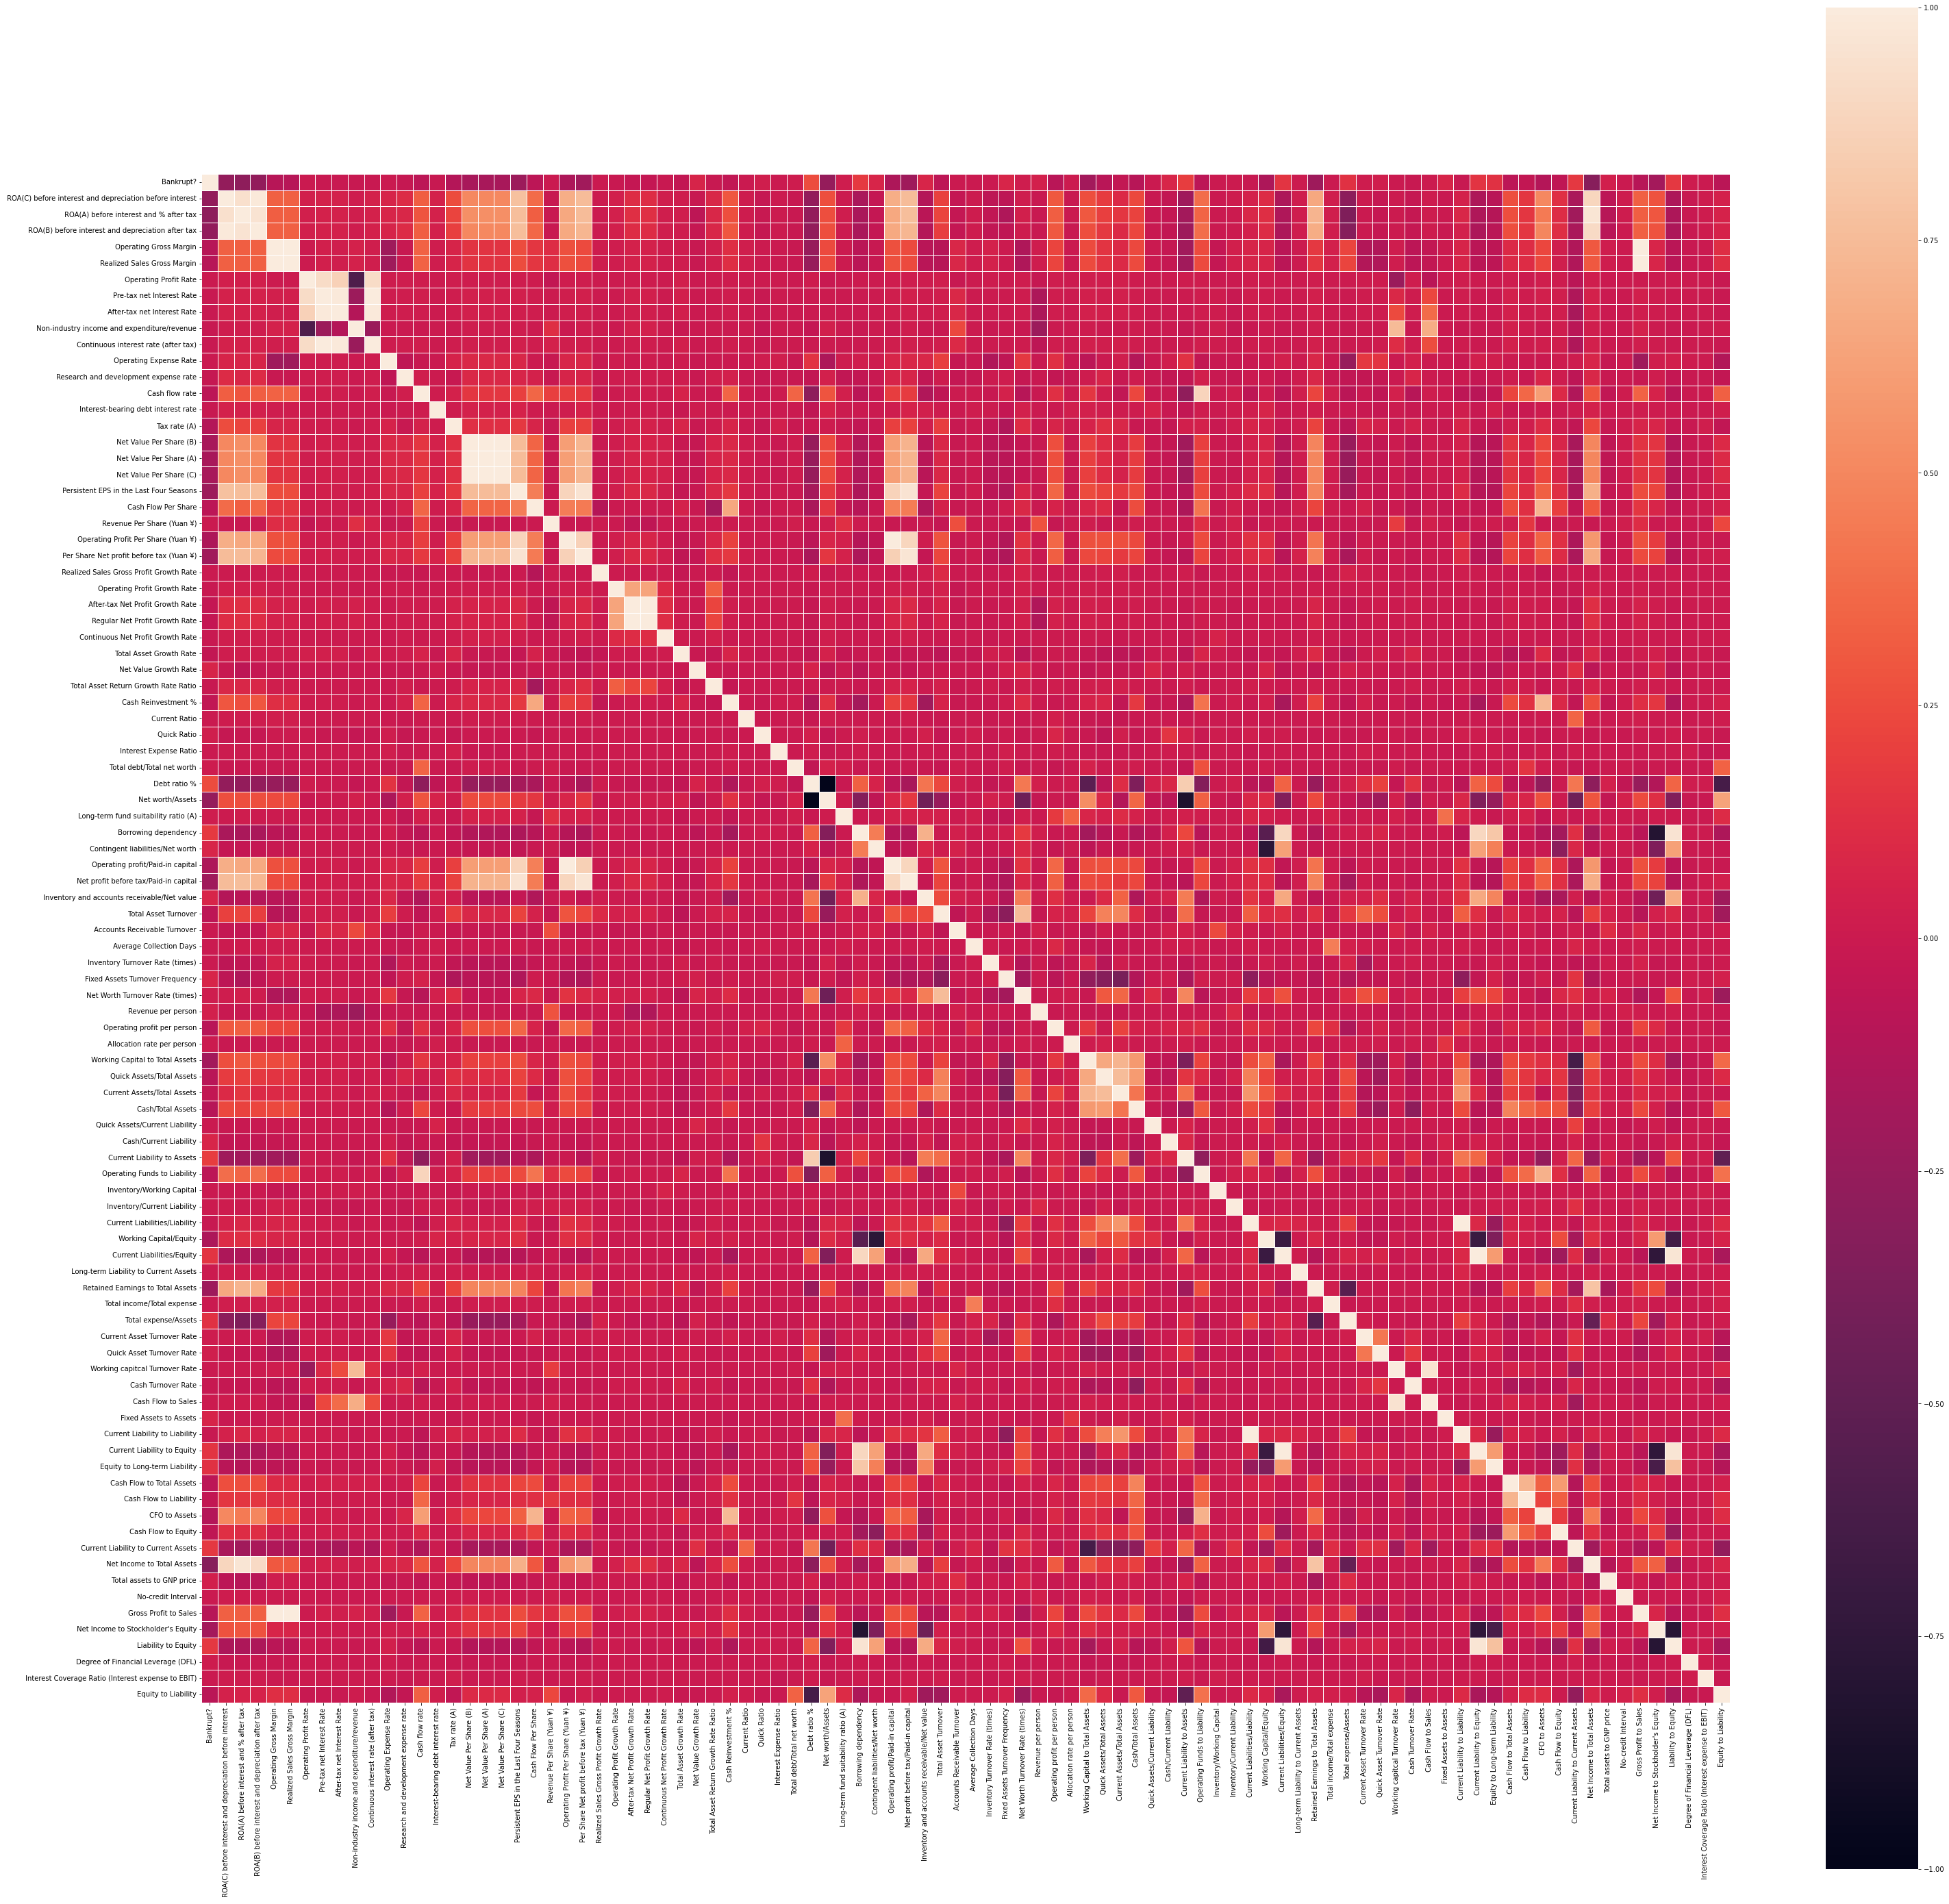

In [7]:
plt.figure(figsize=(50,50))
sns.heatmap(data.corr(), annot=False, square=True, linewidths=.5)
plt.show()

#### Remove redundant columns
As we can see in the above heat map there are several columns with a very high correlation to each other. In some cases we even have complete duplicates of columns with a correlation value of 1. We drop 19 columns that have a correlation higher than 0.9 to an other attribute. We do this to as those redundant features would not have much impact in the prediction and would just consume resources.

In [8]:
cor_matrix = data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_remove = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

data = data.drop(to_remove, axis=1)
print("We drop {} redundant columns".format(len(to_remove)))
print()
data.info()

We drop 19 redundant columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    Operating Gross Margin                                   6819 non-null   float64
 3    Operating Profit Rate                                    6819 non-null   float64
 4    Non-industry income and expenditure/revenue              6819 non-null   float64
 5    Operating Expense Rate                                   6819 non-null   float64
 6    Research and development expense rate                    6819 non-null   float64
 7    Cash flow rate                                           6819 non-null   f

#### Balance of the target class
We have high class inbalance in our data-set with the minority class of Bankrupt companies only being 220 entries compared to 6599 entries of none Bankrupt companies. We will solve this problem at a later point by oversampling the minority class by using the Synthetic Minority Oversampling Technique (SMOTE)

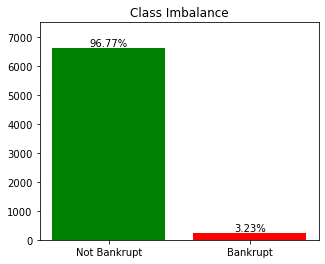

In [9]:
counts = data['Bankrupt?'].value_counts()
percentages = counts / counts.sum()

plt.figure(figsize=(5,4))
plt.bar(x=counts.index, height=counts, color=['green', 'red'], label='count')
for i, p in enumerate(percentages):
    plt.text(i, counts[i], f"{p*100:.2f}%", ha='center', va='bottom')

plt.title('Class Imbalance')
plt.xticks(ticks=[0, 1], labels=['Not Bankrupt', 'Bankrupt'], rotation=0)
plt.ylim(0, 7500)
plt.show()


#### Outlier analysis
In the box plot below we can see the data distribution of our remaining attributes. The colored box in the center shows the middle 50% of the attributes values. Outside that box but still inside the whiskers we can see the upper and lower quartile. Every point outside of the upper and lower whiskers can be considered to be an outlier.

In [10]:
def standardize(_data):
    df = _data.drop('Bankrupt?', axis=1).copy()
    mean = np.mean(df, axis=0)
    std = np.std(df, axis=0)
    df = (df - mean) / std
    return pd.concat([_data['Bankrupt?'], df], axis=1)

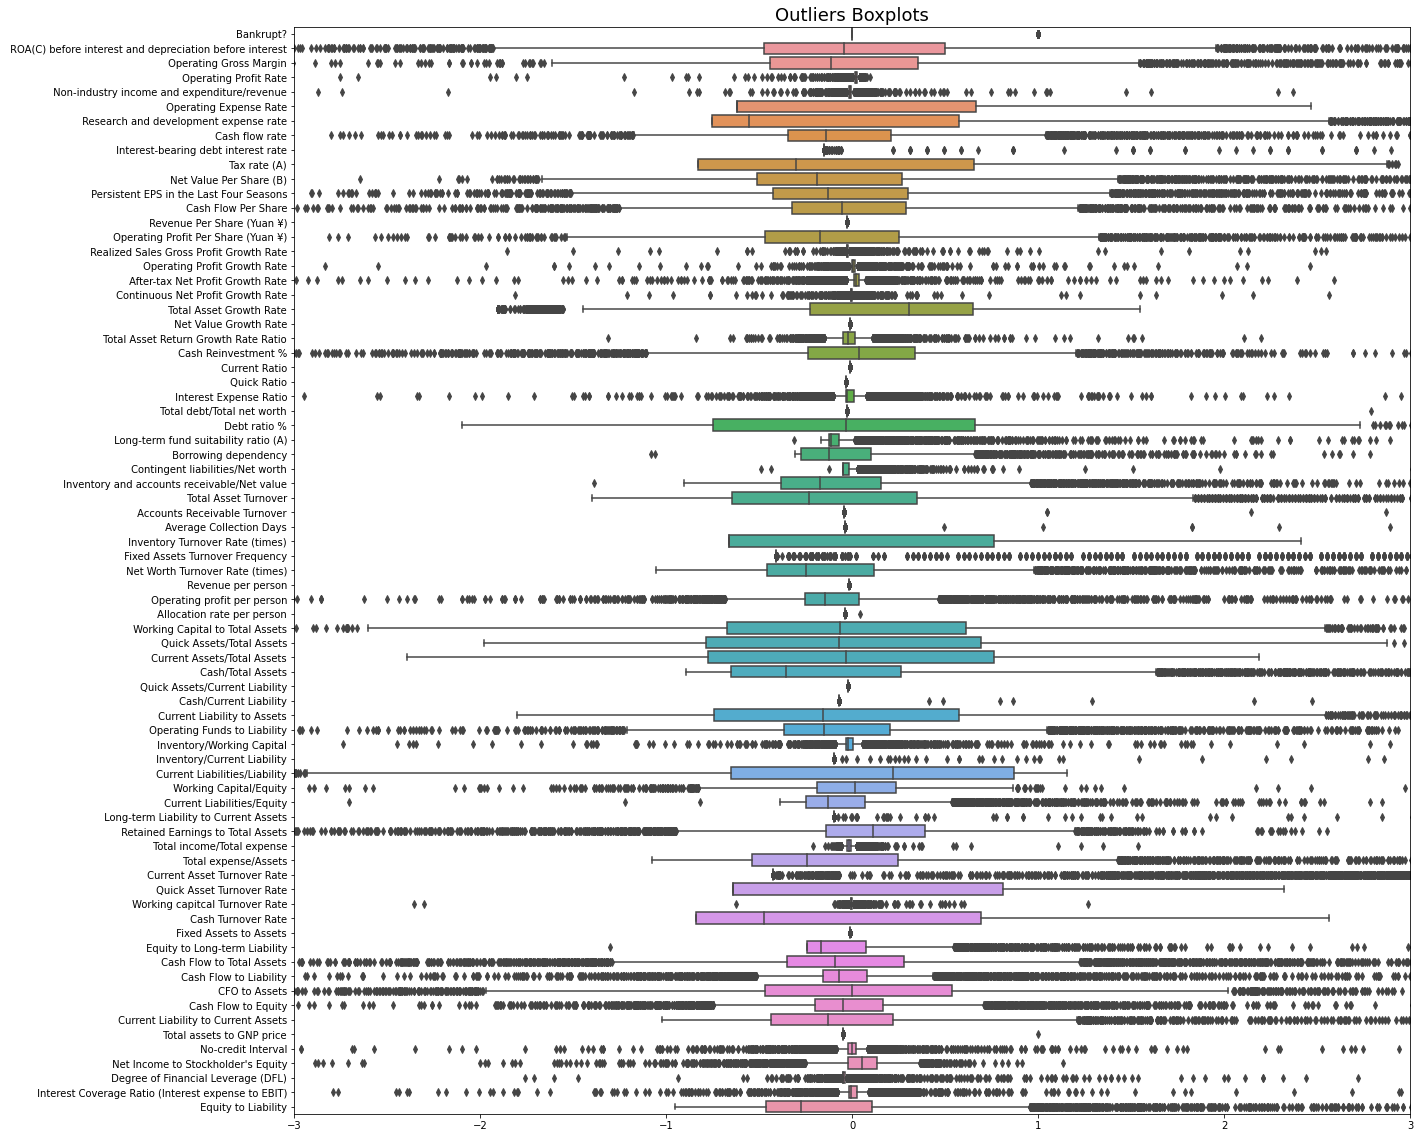

In [11]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = standardize(data), orient="h")
ax.set_title('Outliers Boxplots', fontsize = 18)
ax.set_xlim(-3, 3)
plt.show()


#### Removing outliers
As we can see in the box plot above we have plenty of outliers. Those outliers can negatively impact the performance of the machine learning model. And indeed after removing them by using the z-score the performance of our model was better than before.
Important consideration: after doing some tests I decided to only remove outliers from the majority class. As removing them also from the minority led to a worse performance and an even larger class imbalance.

In [12]:
def removeOutliers(_df, _par):
    df = _df.drop('Bankrupt?', axis=1)
    z = df.apply(zscore)
    
    outliers = z[(z > _par).any(axis=1) | (z < -_par).any(axis=1)]
    df_clean = _df[(z <= _par).all(axis=1) & (z >= -_par).all(axis=1)]
    return df_clean


In [13]:
df = data.copy()
df1 = df[df['Bankrupt?'] == 1]
df0 = df[df['Bankrupt?'] == 0]

df0 = removeOutliers(df0, 3)

data = pd.concat([df1, df0], axis=0)

In [14]:
print("Number of rows left: {}".format(data.count()[0]))

Number of rows left: 4945


#### Standardizing the values
We standardize the feature values by subtracting the mean of each variable from each value and then divide the result by the standard deviation of the variable. As a result every attribute should have zero mean and unit variance. Doing this can improve the performance of some learning models. In my case standardization is necessary for the used **Logistic Regression** Model, the **SVM** Model and the **K Nearest Neighberhood** model whereas it wouldn't be necessary for the Random Forest Classifier. We can see the result of the standardization in the visualization below. The mean of every features is now 0 and the unit variance. 

In [15]:
data = standardize(data)
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),...,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,...,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000
mean,0.04449,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,...,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000
std,0.20620,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,...,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010
min,0.00000,-9.26101,-7.20680,-33.34359,-59.33903,-0.62214,-0.79833,-13.81803,-0.07132,-0.95585,...,-27.68675,-7.72390,-36.76093,-1.54931,-0.02268,-13.48924,-51.35414,-6.76504,-13.01229,-1.37024
25%,0.00000,-0.51348,-0.62373,-0.18270,-0.03135,-0.62214,-0.79833,-0.56323,-0.07132,-0.95585,...,-0.24788,-0.55222,-0.25852,-0.60693,-0.02268,-0.07603,-0.01390,-0.08269,-0.09817,-0.60668
50%,0.00000,-0.01633,-0.13846,0.04873,0.02023,-0.62214,-0.50311,-0.18653,-0.07132,-0.22735,...,-0.06849,-0.00414,-0.04466,-0.14492,-0.02268,0.01077,0.04729,-0.07615,-0.05202,-0.29924
75%,0.00000,0.55412,0.52608,0.33964,0.07264,0.70314,0.61208,0.40502,-0.07132,0.82580,...,0.21786,0.61260,0.24605,0.38645,-0.02268,0.10709,0.11208,-0.04890,0.11526,0.28071
max,1.00000,3.37536,5.64282,2.87784,10.21784,2.40751,3.03488,8.58694,24.69631,7.52302,...,6.34238,6.78699,29.60172,22.94698,51.34128,20.70333,9.74950,59.22665,20.67159,27.71408


#### Find Features with the most correlation to the target class


The more features we use for training and tuning the model the more resources we need and the longer it takes. In addition there are certain features in our data set that have a very low correlation to the our target class (Bankrupt?). Adding them to our training model would only require many more resources and time and not improve the models performance at all. After doing some exploring i decided to proceed with all features that correlate by at least 0.25 to the target class.

In [16]:
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

correlations = X.corrwith(y)

selected_features = correlations[abs(correlations) > 0.25] 

selected_features.sort_values(ascending=False, inplace=True)

top_features_plt = selected_features
top_features = selected_features.index

In [17]:
X_top_corr = data[top_features]

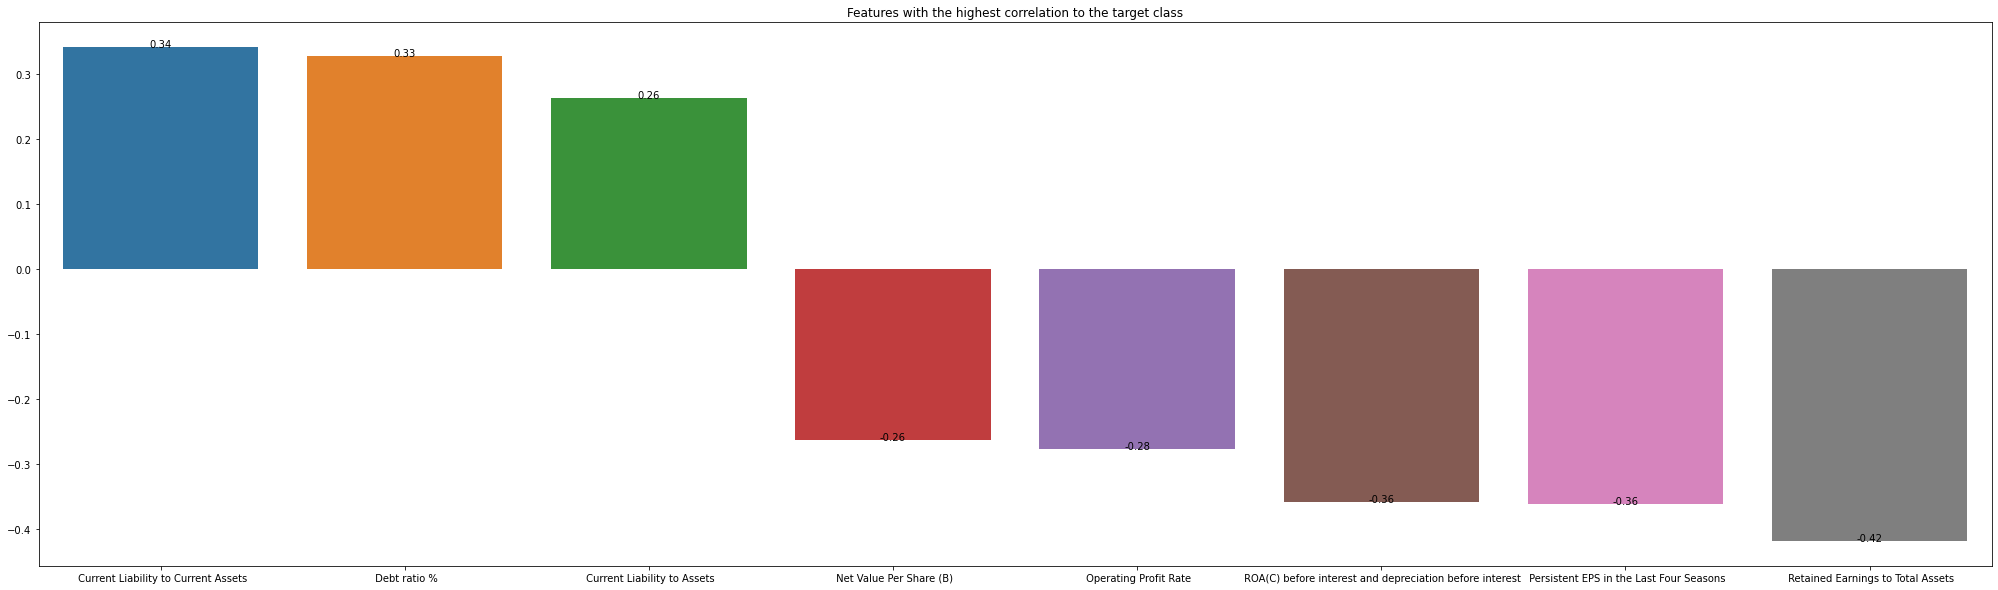

In [18]:
plt.figure(figsize=(35, 10))
sns.barplot(x=top_features_plt.index, y=top_features_plt.values)
for i in range(len(top_features_plt)):
    plt.text(i, top_features_plt.values[i], round(top_features_plt.values[i], 2), ha='center')
    
plt.title('Features with the highest correlation to the target class')
plt.show()

#### Selected Features
By having some domain knowledge in the finance domain I can say that this features will be a good indicator for the financial health of a company as we have mix of asset to liabilities ratios that give a good indication of the companies financial health whereas it also includes other ratios that are a good indicator of the company operating success.

Detailed description of the different ratios:

1. **Current Liability to Current Assets:** This ratio measures a company's ability to pay its short-term debts using its current assets.
2. **Debt ratio:** This ratio measures the proportion of a company's assets that are financed by debt.
3. **Current liability to assets:** This ratio measures the proportion of a company's assets that are financed by current liabilities.
4. **Net value per share:** This ratio measures the net value of a company's assets per share of stock. A low net value per share may indicate that the company's assets are not sufficient to cover its liabilities, which could increase the risk of bankruptcy.
5. **Operating profit rate:** Measures the profitability of a company's core business operations by dividing the profit by its net sales.
6. **Return on assets (ROA):** This ratio measures the profitability of a company relative to its assets.In this case before interest and depreciation before interest
7. **Persistent earnings per share (EPS):** This ratio measures the stability of a company's earnings over time.
8. **Retained earnings to total assets ratio:** This ratio measures the proportion of a company's assets that are financed by retained earnings. 

<AxesSubplot:>

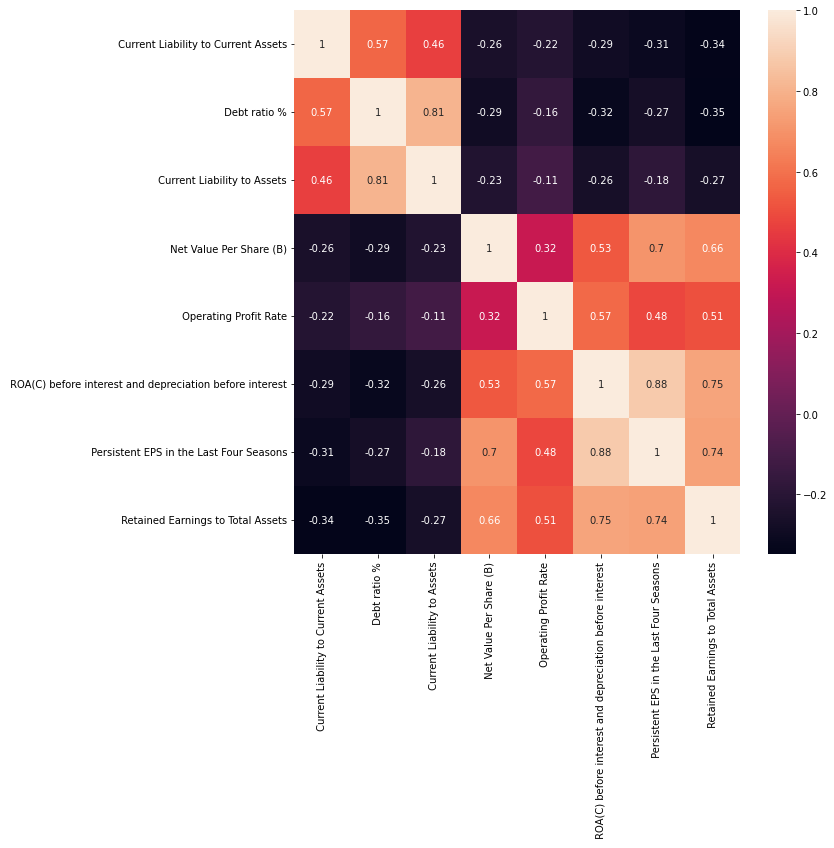

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(X_top_corr.corr(), annot=True)

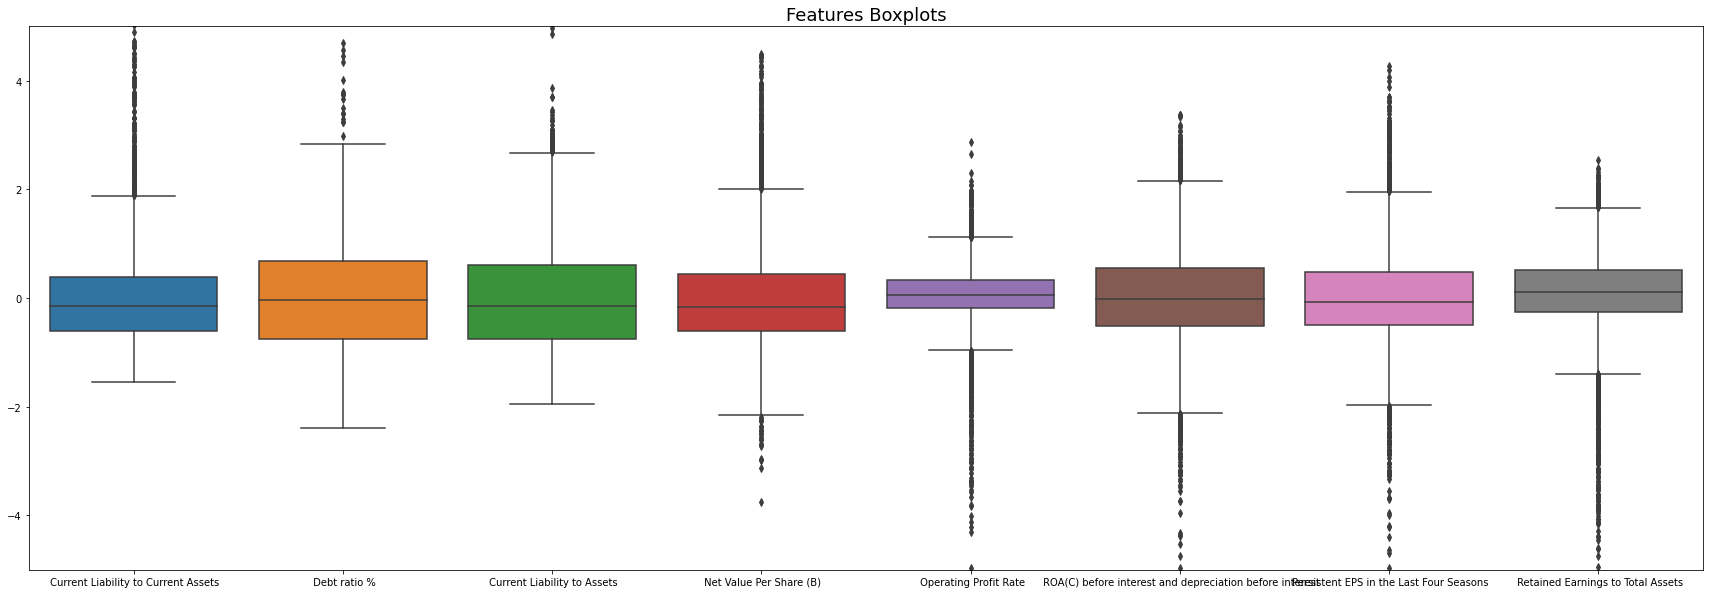

In [20]:
plt.figure(figsize = (30,10))
ax =sns.boxplot(data = X_top_corr)
ax.set_title('Features Boxplots', fontsize = 18)
ax.set_ylim(-5,5)
plt.show()

In [21]:
X = X_top_corr
y = data['Bankrupt?']
data = pd.concat([y, X], axis=1)
X.describe()

,Current Liability to Current Assets,Debt ratio %,Current Liability to Assets,Net Value Per Share (B),Operating Profit Rate,ROA(C) before interest and depreciation before interest,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets
count,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000,4945.00000
mean,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000
std,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010,1.00010
min,-1.54931,-2.38339,-1.95420,-5.17943,-33.34359,-9.26101,-10.08311,-12.62374
25%,-0.60693,-0.76071,-0.76021,-0.60259,-0.18270,-0.51348,-0.49999,-0.25210
50%,-0.14492,-0.02838,-0.14442,-0.16696,0.04873,-0.01633,-0.06650,0.11658
75%,0.38645,0.68173,0.61420,0.44328,0.33964,0.55412,0.48484,0.51459
max,22.94698,8.62249,5.77322,4.48340,2.87784,3.37536,4.27263,2.53045


## Modeling and Tuning

I will try out 4 different classsification models on our data. In order to facilitate the training and parameter tuning of the different models I built a function that performs all basic tuning steps. As an input parameter for the function we have the model Object, the different hyperparameters that can be used, the name of the model as a string and the Metrics Object where the results are stored. 

1. As a first step I split the data-set in train and test set with a 80/20 ration (80% train, 20% test) by using the StratifiedShuffleSplit Object. By using that particular splitting method the class balance in both sets remains the same which is important when having large class imbalances as in my case.

2. The train set was further split in 5 smaller train and test sets. On those 5 train and test sets a cross validation is performed in order to find the best parameters for the used classification model.

3. SMOTE (Synthetic Minority Over-sampling Technique) is a method to oversample a dataset. We use it to balance the class distribution in our training set by synthesizing new instances of the 'Bankrupt?' minority class.

4. Finally the model is tested out on the test set by using the optimal parameter.

**Notebook Execution Performance Considerations**: In order to improve the compilation time of the notebook i checked out the best hyperparameters for the different models with the first disabled function you find under each Model. And called the model by only passing the optimal hyperparameters to the training function. This way the GridSearchCV is not executed which saves a lot of time during the execution of the model.

In [22]:
def training(Model, _modelParams, _data, _name, MetricsObject):
    
    X = _data.drop('Bankrupt?', axis=1)
    y = _data['Bankrupt?']
    
    allDataSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in allDataSplit.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    trainSplit = StratifiedShuffleSplit(n_splits=5, random_state=None)
    for train_index, test_index in trainSplit.split(X_train, y_train):
        X_train_train, X_train_test = X.iloc[train_index], X.iloc[test_index]
        y_train_train, y_train_test = y.iloc[train_index], y.iloc[test_index]
    
    if _modelParams==None:
        for train, test in trainSplit.split(X_train_train, y_train_train):
            pipeline = make_pipeline(SMOTE(sampling_strategy='minority')) 
            fitting_model = Model.fit(X_train_train.iloc[train], y_train_train.iloc[train])
        best_model = Model
    else:
        randSearchModel = RandomizedSearchCV(Model, _modelParams, n_iter=4)
        for train, test in trainSplit.split(X_train_train, y_train_train):
            pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), randSearchModel) 
            fitting_model = pipeline.fit(X_train_train.iloc[train], y_train_train.iloc[train])
        print(randSearchModel.best_params_)
        best_model = randSearchModel.best_estimator_
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_train, y_train_train)
    
    best_model.fit(X_train_resampled, y_train_resampled)
    y_pred = best_model.predict(X_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    showMetrics(_name, y_test, y_pred, MetricsObject)

### Metrics used for the Model Comparison

In classification tasks with imbalanced classes, it is important to consider the performance metrics carefully. The standard metric of accuracy may not be the most informative in these cases because it does not take into account the balance of the classes. For example, in our case where the minority class (bankruptcy) is only 3% of the data, even if all cases were classified as not bankrupt, we would still have an falsely high accuracy of 97%. This means that the model could be performing poorly on the minority class, but still have a high overall accuracy.

To address this issue, we should focus on metrics that take into account the balance of the classes, such as **balanced accuracy**. In addition, the **F1 score**, which is a combination of precision and recall, can be useful for imbalanced class problems because it considers both the false positive and false negative rates. The **ROC curve**, which plots the true positive rate against the false positive rate, can also be helpful in evaluating the performance of the model on the minority class. Finally, the **precision-recall curve**, which plots precision against recall, can be a useful tool for comparing different models and for identifying the optimal trade-off between precision and recall. The last metric is especially useful in cases such as in mine with high class imbalances.

Overall, by considering these balanced performance metrics, we can get a more accurate and fair assessment of the model's performance on the imbalanced target class.


In [23]:
class MetricsObj:
    
    def __init__(self, title):
        self.title = title
        self.model_metrics = []
        self.results = pd.DataFrame({}, columns=['Model', 'F1', 'Balanced_Accuracy', 'Precision', 'Recall', 'Average_Precision'])
    
    def addModel(self, fpr, tpr, auc, model_name,f1, balanced_accuracy, average_precision, precision, recall):
        x = [fpr, tpr, auc, model_name]
        
        self.model_metrics.append([fpr, tpr, auc, model_name])
        r = r = pd.DataFrame({'Model': [model_name], 'F1':[f1], 'Balanced_Accuracy':[balanced_accuracy], 'Precision':[precision], 'Recall':[recall], 'Average_Precision':[average_precision]})
        self.results = pd.concat([self.results, r], axis=0)
    
    def plot(self):
        plt.figure(figsize=(5,5), dpi=100)

        for x in self.model_metrics:
            plt.plot(x[0], x[1],  label="{} AUC: {}".format(x[3], x[2]))

        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    def showValues(self):
        return self.results
        
    def resetValues(self):
        self.model_metrics = []

In [24]:
ModelComparison = MetricsObj("Comparison of the models")

In [25]:
def showMetrics(_name, _y_test, _pred_y, MetricsObject=ModelComparison):
    accuracy = round(accuracy_score(_y_test, _pred_y), 2)
    balanced_accuracy = round(balanced_accuracy_score(_y_test, _pred_y), 2)
    f1 = round(f1_score(_y_test, _pred_y, average='weighted'), 2)
    recall = round(recall_score(_y_test,  _pred_y, average='weighted'), 2)
    precision = round(precision_score(_y_test, _pred_y, average='weighted', zero_division=1), 2)
    fpr, tpr, thresholds = roc_curve(_y_test, _pred_y)
    average_precision = round(average_precision_score(_y_test, _pred_y), 2)
    auc = round(roc_auc_score(_y_test, _pred_y), 2)
    
    MetricsObject.addModel(fpr, tpr, auc, _name, f1, balanced_accuracy,average_precision, precision, recall)
    
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()
    
    print(classification_report(_y_test, _pred_y))
    print("Balanced Accuracy: {}\nAverage-Precision: {}\nAUC Score: {}".format(balanced_accuracy, average_precision, auc ))


Should the notebook take to much time to compile

### K Nearest Neighborhood


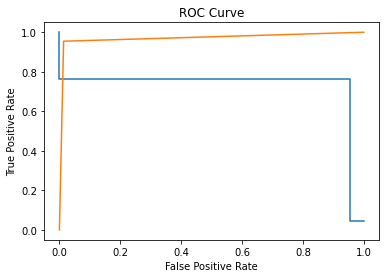

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       945
           1       0.76      0.95      0.85        44

    accuracy                           0.98       989
   macro avg       0.88      0.97      0.92       989
weighted avg       0.99      0.98      0.99       989

Balanced Accuracy: 0.97
Average-Precision: 0.73
AUC Score: 0.97


In [26]:
##uncomment the following function to performa also GridSearchCV and prints optimal hyperparameter:
#training(KNeighborsClassifier(), {"n_neighbors": list(range(1,5)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, data ,"K Nearest Neighbour", ModelComparison)

training(KNeighborsClassifier(n_neighbors=2, algorithm='auto', ), None, data ,"K Nearest Neighbour", ModelComparison)


### Logistic Regression

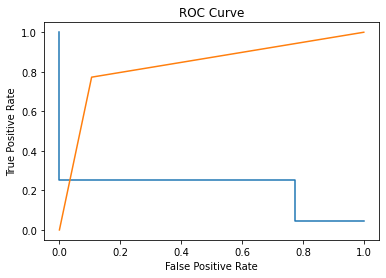

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       945
           1       0.25      0.77      0.38        44

    accuracy                           0.89       989
   macro avg       0.62      0.83      0.66       989
weighted avg       0.96      0.89      0.91       989

Balanced Accuracy: 0.83
Average-Precision: 0.21
AUC Score: 0.83


In [27]:
##uncomment the following function to performa also GridSearchCV and prints optimal hyperparameter:
#training(LogisticRegression(solver='liblinear'), {'C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001, ]}, data, "Logistic Regression", ModelComparison)
training(LogisticRegression(solver='liblinear', C=100, ), None, data, "Logistic Regression", ModelComparison)

### Random Forest Classifier

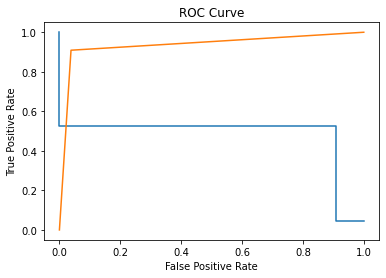

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       945
           1       0.53      0.91      0.67        44

    accuracy                           0.96       989
   macro avg       0.76      0.94      0.82       989
weighted avg       0.97      0.96      0.96       989

Balanced Accuracy: 0.94
Average-Precision: 0.48
AUC Score: 0.94


In [28]:
##uncomment the following function to performa also GridSearchCV and prints optimal hyperparameter:
#training(RandomForestClassifier(), {"max_depth": [3, 5, 10, None],"n_estimators": [100, 200, 300, 400, 500]}, data, "Random Forest Classifier", ModelComparison)
training(RandomForestClassifier(max_depth=10, n_estimators=400), None, data, "Random Forest Classifier", ModelComparison)

### Support Vector Machine 


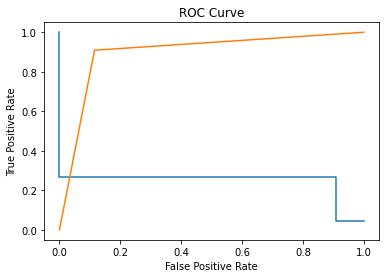

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       945
           1       0.27      0.91      0.41        44

    accuracy                           0.89       989
   macro avg       0.63      0.90      0.68       989
weighted avg       0.96      0.89      0.91       989

Balanced Accuracy: 0.9
Average-Precision: 0.25
AUC Score: 0.9


In [29]:
##uncomment the following function to performa also GridSearchCV and prints optimal hyperparameter:
#training(SVC(), {'C': [1,10,20],'kernel': ['rbf','linear']}, data, "Support Vector Classifier", ModelComparison)
training(SVC(C=10, kernel='rbf'), None, data, "Support Vector Classifier", ModelComparison)

## Result 
Based on F1-Score and Balanced Accuracy we have two dominant models:
- K Nearest Neighbour
- Random Forest Classifier

The K Nearest Neighbour model had the highest F1 score, which is a measure of a model's overall accuracy taking into account both precision and recall. This model also had the highest recall, meaning that it was able to correctly identify a higher proportion of positive cases compared to the other models.

The Random Forest Classifier had the highest balanced accuracy, which is the average of the sensitivity and specificity of the model. This suggests that this model may be more effective at correctly predicting both the majority and minority classes.

Overall, it seems both models give a good prediction.

#### Cost of false negatives and false positives
It is generally more costly to have false negatives than false positives in my use case. This is because a false negative means that the model predicted that a company would not go bankrupt, but in reality, it did go bankrupt. This can lead to financial losses for the individuals or organizations that relied on the model's prediction. On the other hand, a false positive means that the model predicted that a company would go bankrupt, but in reality, it did not.  Still those cost's are only opportunity costs meaning the cost of a lost opportunity meaning they are only theoretical and didn't realize.
Hence the cos of false negatives is higher in our model we have to put more weight on the Recall metric as that metric is bias towards C(Yes|Yes) & C(No|Yes)

##### ROC Curve
I have chosen to use the receiver operating characteristic (ROC) curve to evaluate the performance of my model because it is a robust tool that allows me to compare the true positive rate and false positive rate of my classifier, and it is independent of the class distribution. Additionally, the ROC curve enables me to compute various performance measures, such as the area under the curve (AUC), which is a useful metric for comparing the overall performance of different classifiers. Therefore, I believe that using the ROC curve is an appropriate method for evaluating my classification model in this imbalanced dataset.

#### Recall
In addition to the ROC Curve also a very important es explained earlier is the Recall metric. 

So putting together all these considerations in my situation the **K-Nearest Neighbor Classification** Model with the Hyperparameters n_neighbors=2 and algorithm='auto' would be the best choice for the task at hand.


#### Limitation of the model: 
The model was only trained on rather old data from the Taiwan stock exchange and is therefore only representative for companies that are listed on the same stock exchange and from the same timeframe. In addition a hube problem was that we had only the entries of around 200 bankrupt companies. Therefore oversampling was required which may have led to an overfitting of the prediction model.

In [30]:
ModelComparison.showValues().head()

,Model,F1,Balanced_Accuracy,Precision,Recall,Average_Precision
0,K Nearest Neighbour,0.99000,0.97000,0.99000,0.98000,0.73000
0,Logistic Regression,0.91000,0.83000,0.96000,0.89000,0.21000
0,Random Forest Classifier,0.96000,0.94000,0.97000,0.96000,0.48000
0,Support Vector Classifier,0.91000,0.90000,0.96000,0.89000,0.25000


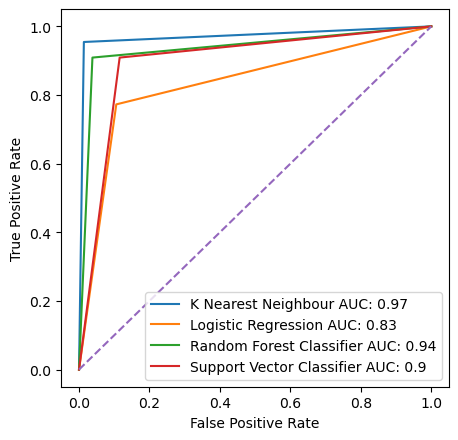

In [31]:
ModelComparison.plot()